<h1 style="font-size:30px;">DeepLabv3+ with EfficientNetv2_S Backbone</h1>

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 15.4 MB/s eta 0:00:00


In [ ]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

## Set Seeds for Reproducibility

In [ ]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

## Download and Extract Dataset

In [ ]:
# Download and dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        # Extract tarfile.
        if save_path.endswith(".zip"):
            with ZipFile(save_path) as zip:
                zip.extractall(os.path.split(save_path)[0])

        print("Done")
    except:
        print("Invalid file")

In [ ]:
DATASET_URL = r"https://www.dropbox.com/scl/fi/9k8t9619b4x0hegued5c5/Water-Bodies-Dataset.zip?rlkey=tjgepcai6t74yynmx7tqsm7af&dl=1"
DATASET_DIR = "Water-Bodies-Dataset"
DATASET_ZIP_PATH = os.path.join(os.getcwd(), f"{DATASET_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(DATASET_DIR):
    download_and_unzip(DATASET_URL, DATASET_ZIP_PATH)
    os.remove(DATASET_ZIP_PATH)

## Configurations

### Data Configuration

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (256, 256)
    BATCH_SIZE:          int = 16
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.2

### Training Configuration

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL:           str = "efficientnetv2_s_imagenet"
    EPOCHS:          int = 100
    LEARNING_RATE: float = 1e-4
    CKPT_DIR:        str = os.path.join("checkpoints_"+"_".join(MODEL.split("_")[:2]),
                                        "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".weights.h5")
    LOGS_DIR:        str = "logs_"+"_".join(MODEL.split("_")[:2])

In [ ]:
train_config = TrainingConfig()
data_config = DatasetConfig()

## Dataset Preparation

In [ ]:
data_images = glob.glob(os.path.join(DATASET_DIR, "Images", "*.jpg"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "Masks", "*.jpg"))

# Shuffle the data paths before data preparation.
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)
data_images, data_masks = zip(*zipped_data)
data_images = list(data_images)
data_masks = list(data_masks)

In [ ]:
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))

### Train-Validation Split

We are maintaining a **95-5** split ratio for training and validation samples respectively.

In [ ]:
SPLIT_RATIO = 0.05
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

In [ ]:
print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 2699
Validation samples: 142


### Load Data and Threshold Masks

In [ ]:
def read_image_mask(image_path, mask=False, size = data_config.IMAGE_SIZE):
    image = tf.io.read_file(image_path)

    if mask:
        image = tf.image.decode_jpeg(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=size, method = "bicubic")

        image_mask = tf.zeros_like(image)
        cond = image >=200
        updates = tf.ones_like(image[cond])
        image_mask = tf.tensor_scatter_nd_update(image_mask, tf.where(cond), updates)
        image = tf.cast(image_mask, tf.uint8)

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=size, method = "bicubic")
        image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    return image

In [ ]:
def load_data(image_list, mask_list):
    image = read_image_mask(image_list)
    mask  = read_image_mask(mask_list, mask=True)
    return {"images":image, "segmentation_masks":mask}

In [ ]:
train_ds = train_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

In [ ]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks

## Ground Truth Visualizations

In [ ]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  0,    0),    # Background
    1: (102, 204, 255),  # Waterbody
 }

In [ ]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):

    # single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2]+(3,))

    for k in color_map.keys():
        output[num_arr==k] = color_map[k]

    return output.astype(np.uint8)

In [ ]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):

    alpha = 1.0 # Transparency for the original image.
    beta  = 0.7 # Transparency for the segmentation map.
    gamma = 0.0 # Scalar added to each sum.

    image = image.astype(np.uint8)

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [ ]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):

    # Create RGB segmentation map from grayscale segmentation map.
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask

    if len(data_list)==3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask

    # Create the overlayed image.
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)

    data_list.append(overlayed_image)

    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)

    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")

        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")

        else:
            axis.imshow(data_list[idx])

        axis.axis('off')

    plt.show()

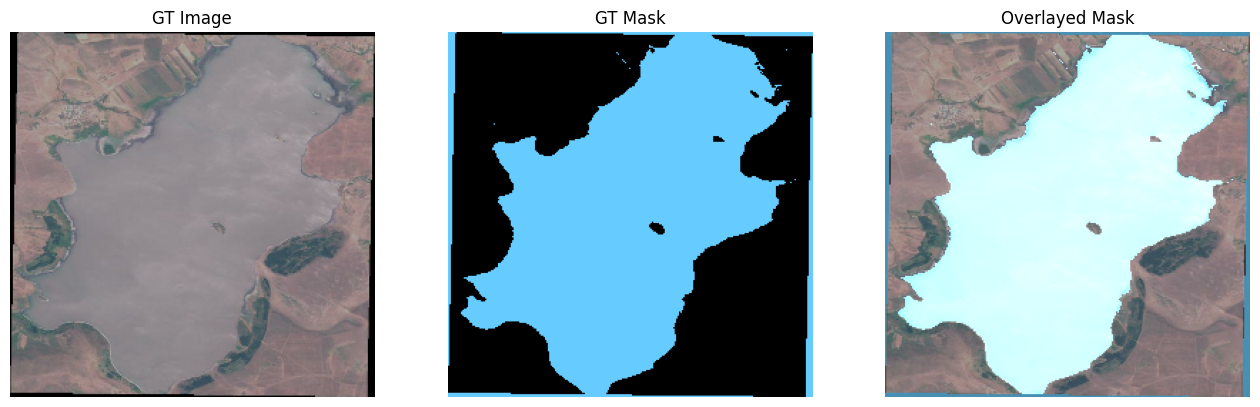

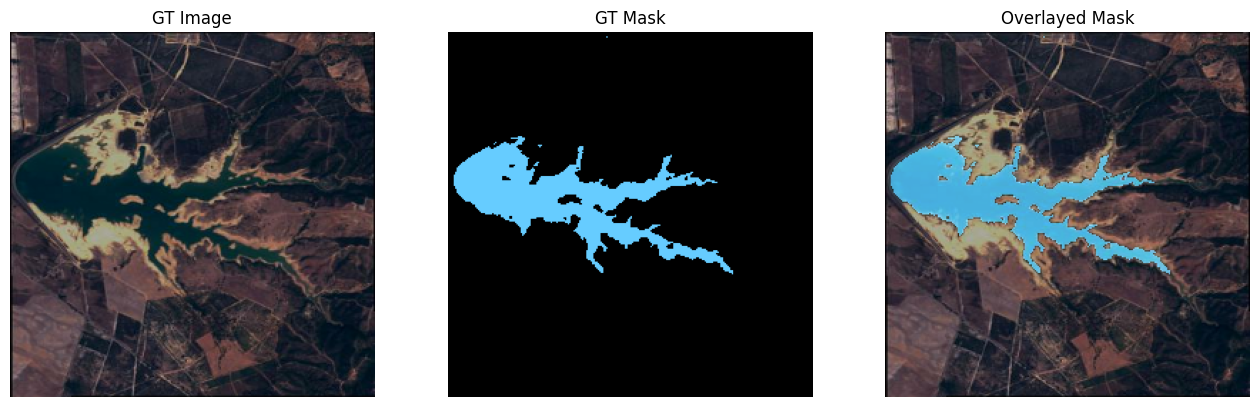

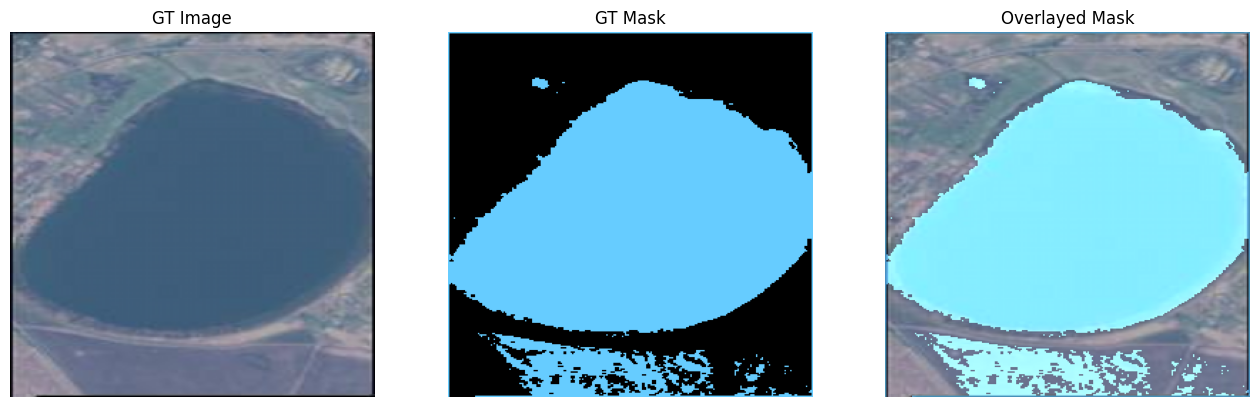

In [ ]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):

    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=True)

## Data Augmentation

We will use the following transforms as augmentations:
* RandomFlip (default mode is **"horizontal"**, with a probability of `0.5`)
* Random Brightness
* Random Contrast

In [ ]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

Let us prepare the final training and validation datasets.

In [ ]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

### Visualize Augmented Data

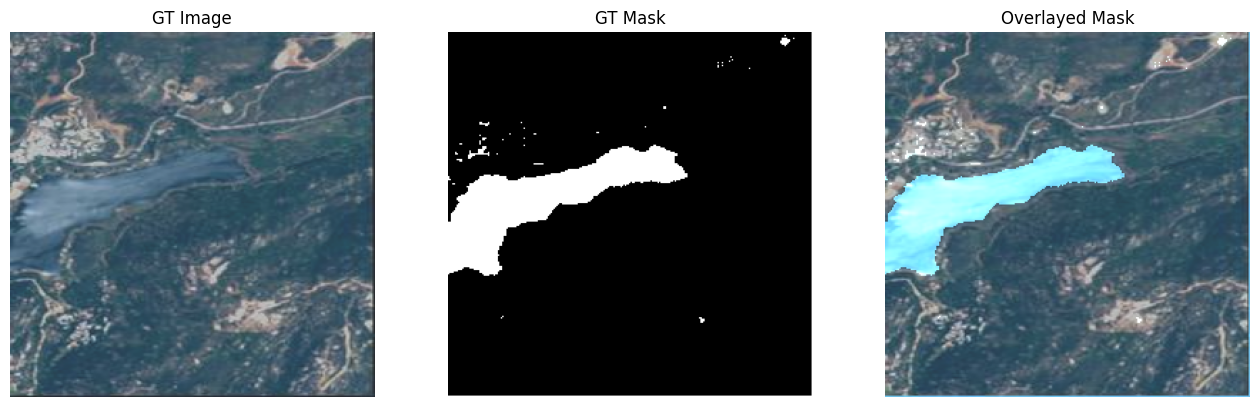

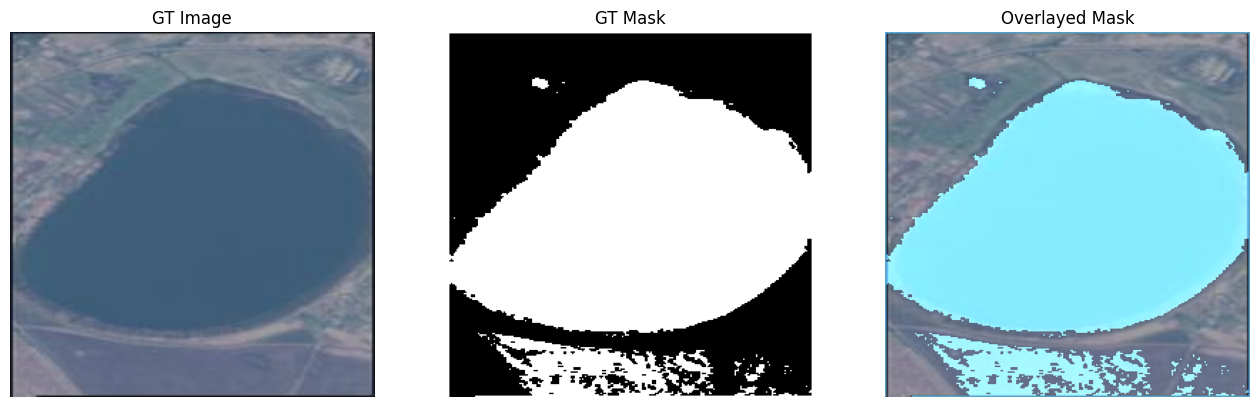

In [ ]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

## Model Architecture

We will use `efficientnetv2_s_imagenet` feature extractor on top of the DeepLabv3 Head.

In [ ]:
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )
print(model.summary())

100%|██████████| 1.79k/1.79k [00:00<00:00, 1.67MB/s]


100%|██████████| 78.6M/78.6M [00:02<00:00, 32.0MB/s]


Model: "deep_lab_v3_plus"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 64, 64, 48),   │     20,331,360 │ input_layer[0][0]      │
│                           │ (None, 8, 8, 1280)]    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_pyramid_pooling   │ (None, 8, 8, 256)      │      9,836,544 │ functional[0][1]       │
│ (SpatialPyramidPooling)   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output_upsampling │ (None, 64, 64, 256)    │              0 │ spatial_pyramid_pooli… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 64, 64, 48)     │          2,496 │ functional[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 304)    │              0 │ encoder_output_upsamp… │
│                           │                        │                │ sequential_7[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_8 (Sequential) │ (None, 256, 256, 2)    │         79,360 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,249,760 (115.39 MB)

 Trainable params: 30,092,208 (114.79 MB)

 Non-trainable params: 157,552 (615.44 KB)

None


## Evaluation Metrics

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

In [ ]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

### Tensorboard and ModelCheckpoint Callbacks

In [ ]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [ ]:
# Build model

# Get callbacks.
callbacks = get_callbacks(train_config)

# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou],
)

In [ ]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=train_config.EPOCHS,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7516 - loss: 0.5177 - mean_iou: 0.5133
Epoch 1: val_mean_iou improved from -inf to 0.62169, saving model to checkpoints_efficientnetv2_s/deeplabv3_plus_efficientnetv2_s.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 244s 782ms/step - accuracy: 0.7520 - loss: 0.5172 - mean_iou: 0.5136 - val_accuracy: 0.8182 - val_loss: 0.4707 - val_mean_iou: 0.6217
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8556 - loss: 0.3417 - mean_iou: 0.6532
Epoch 2: val_mean_iou improved from 0.62169 to 0.68118, saving model to checkpoints_efficientnetv2_s/deeplabv3_plus_efficientnetv2_s.weights.h5
169/169 ━━━━━━━━━━━━━━━━━━━━ 118s 696ms/step - accuracy: 0.8557 - loss: 0.3416 - mean_iou: 0.6533 - val_accuracy: 0.8629 - val_loss: 0.3407 - val_mean_iou: 0.6812
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8774 - loss: 0.2965 - mean_iou: 0.6951
Epoch 3: val_mean_iou improved from 0.68118 to 0.71012, saving mo

#### Load Fine-tuned Model Weights

In [ ]:
model.load_weights(train_config.CKPT_DIR)

#### Perform Evaluation

In [ ]:
evaluate = model.evaluate(valid_dataset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.9240 - loss: 0.2742 - mean_iou: 0.8202


## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [ ]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)

        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break


In [ ]:
inference(model, valid_dataset, samples_to_plot=10)

NameError: name 'model' is not defined

In [ ]:
def load_model(model_path):
  """
  Loads a trained model from a given path.
  If the path ends with '.weights.h5', it assumes that only weights are saved and
  recreates the model architecture before loading the weights.
  """
  if model_path.endswith(".weights.h5"):
    # Example for deeplabv3_plus_resnet50_v2, replace with your model if different
    model = create_deeplabv3_plus_resnet50v2()
    model.load_weights(model_path)  # Load the weights into the created model
  else:
    # If it's a standard .h5 or .keras file, load directly
    model = tf.keras.models.load_model(model_path, compile=False)
  return model